In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seml
#from sklearn.manifold import TSNE
from openTSNE import TSNE
from sklearn.decomposition import PCA
import torch
import networkx as nx
import scipy.sparse as sp
import itertools
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seml/database.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
from data.construct import load_data_from_configuration
import data.constants as data_constants
from data.util import assert_integrity
import configuration

In [4]:
base_data_config = {
    'dataset': 'cora_full',  
    'num_dataset_splits': 5, 
    'train_portion': 20, 'val_portion': 20, 
    'test_portion': 0.6, 
    'test_portion_fixed': 0.2, 
    'train_labels_remove_other': True, 
    'val_labels_remove_other': True, 
    'split_type': 'uniform', 
    'type': 'npz', 
    'base_labels': ['Artificial_Intelligence/NLP', 'Artificial_Intelligence/Data_Mining', 'Artificial_Intelligence/Speech', 'Artificial_Intelligence/Knowledge_Representation', 'Artificial_Intelligence/Theorem_Proving', 'Artificial_Intelligence/Games_and_Search', 'Artificial_Intelligence/Vision_and_Pattern_Recognition', 'Artificial_Intelligence/Planning', 'Artificial_Intelligence/Agents', 'Artificial_Intelligence/Robotics', 'Artificial_Intelligence/Expert_Systems', 'Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intelligence/Machine_Learning/Rule_Learning', 'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning', 'Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance'], 
    'train_labels': ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intelligence/Machine_Learning/Rule_Learning', 'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'], 
    'val_labels': ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intelligence/Machine_Learning/Rule_Learning', 'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning', 'Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance'], 
    'corpus_labels': ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intelligence/Machine_Learning/Rule_Learning', 'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'], 'preprocessing': 'word_embedding', 'language_model': 'bert-base-uncased', 'min_token_frequency' : 10
}
data_config = configuration.get_experiment_configuration({
            'data' : base_data_config,
        })['data']

In [5]:
data_list, data_test_fixed = load_data_from_configuration(data_config)

In [6]:
def plot_community_structure_at_axis(data, title, ax, masked_only=False):
    class_to_idx = {class_ : idx for idx, class_ in enumerate(sorted(sorted(data.label_to_idx), key=lambda k: 0 if 'Machine_Learning' in k else 1))}
    x, y, edge_index, mask = data.x.numpy(), data.y.numpy(), data.edge_index.numpy(), data.mask.numpy()
    n = x.shape[0]
    A = sp.coo_matrix((np.ones(edge_index.shape[1]), edge_index), shape=(n, n)).tocsr()
    if not masked_only:
        mask[:] = True
    


    num_intra_cluster_edges = np.zeros((len(class_to_idx), len(class_to_idx)), dtype=int)
    for (class_i, i), (class_j, j) in itertools.product(class_to_idx.items(), repeat=2):
        num_intra_cluster_edges[i, j] = A[(y == data.label_to_idx[class_i]) & mask][:, (y == data.label_to_idx[class_j]) & mask].nnz

    assert num_intra_cluster_edges.sum() == edge_index.shape[1] or masked_only, f'Bug!'
    assert np.allclose(num_intra_cluster_edges, num_intra_cluster_edges.T), f'Graph is not symmetric'

    class_names = [None for _ in range(len(class_to_idx))]
    for class_, idx in class_to_idx.items():
        class_names[idx] = class_


    sns.heatmap(pd.DataFrame(num_intra_cluster_edges, class_names, class_names), ax=ax, norm=LogNorm())
    ax.tick_params(left=False, bottom=False) ## other options are right and top
    ax.set_title(title)

def plot_commumity_structure(datasets, data_test_fixed, masked_only=False):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), squeeze=False, sharex = True, sharey = True)
    plot_community_structure_at_axis(datasets[data_constants.TRAIN][0], 'train', axs[0, 0], masked_only = masked_only)
    plot_community_structure_at_axis(datasets[data_constants.BASE][0], 'base', axs[0, 2], masked_only = masked_only)
    plot_community_structure_at_axis(data_test_fixed[0], 'test-fixed', axs[0, 1], masked_only = masked_only)
    plot_community_structure_at_axis(datasets[data_constants.VAL_REDUCED][0], 'val on train graph', axs[1, 0], masked_only = masked_only)
    plot_community_structure_at_axis(datasets[data_constants.VAL_TRAIN_LABELS][0], 'val with train labels', axs[1, 1], masked_only = masked_only)
    plot_community_structure_at_axis(datasets[data_constants.VAL][0], 'val', axs[1, 2], masked_only = masked_only)
    plot_community_structure_at_axis(datasets[data_constants.TEST_REDUCED][0], 'test on train graph', axs[2, 0], masked_only = masked_only)
    plot_community_structure_at_axis(datasets[data_constants.TEST_TRAIN_LABELS][0], 'test with train labels', axs[2, 1], masked_only = masked_only)
    plot_community_structure_at_axis(datasets[data_constants.TEST][0], 'test', axs[2, 2], masked_only = masked_only)
    return fig, axs

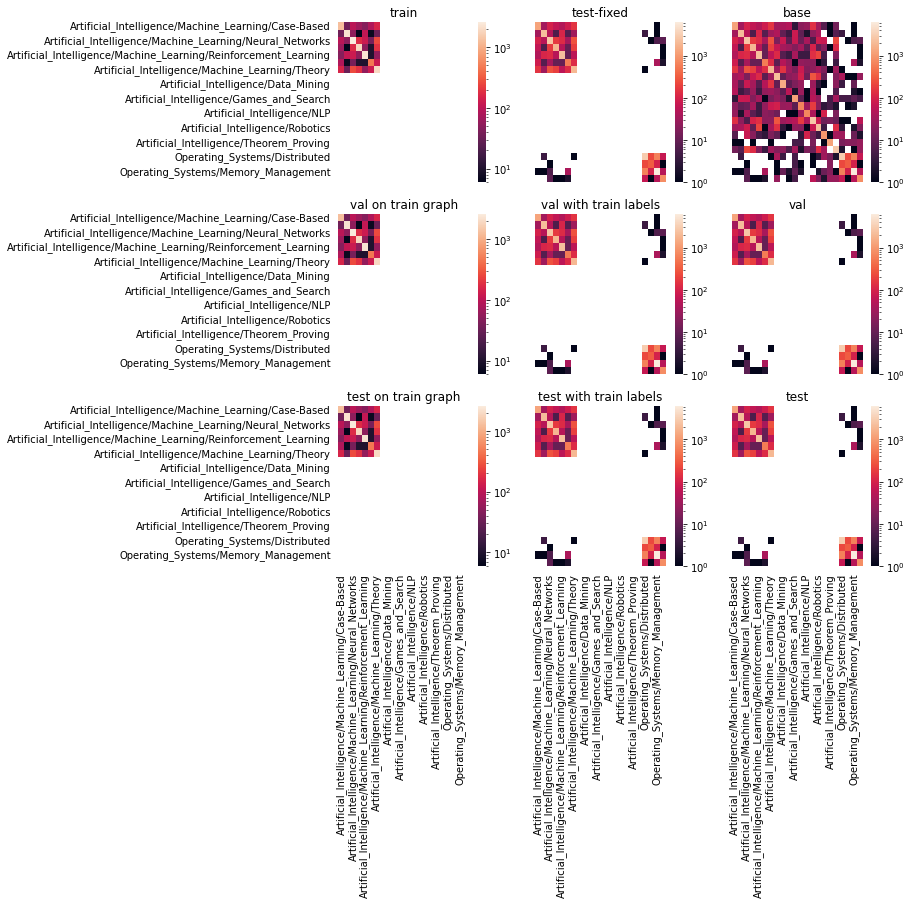

In [7]:
_, _ = plot_commumity_structure(data_list[0], data_test_fixed)

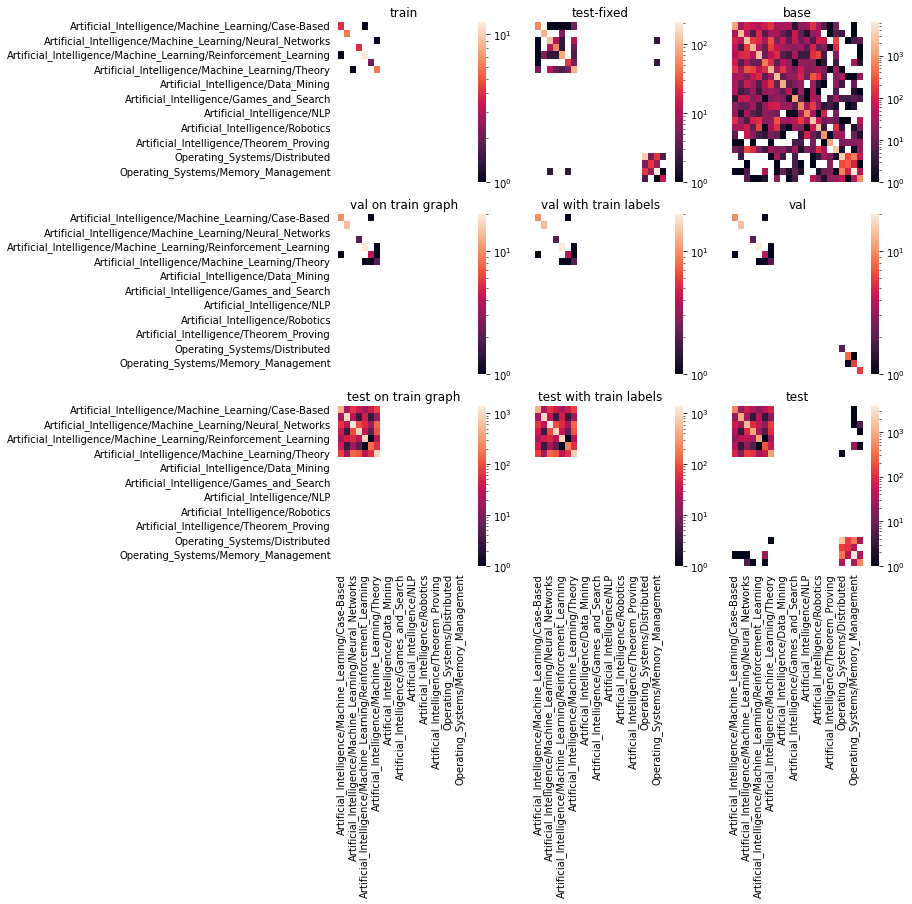

In [8]:
_, _ = plot_commumity_structure(data_list[0], data_test_fixed, masked_only=True)